COMP1804 22-23 Tutorial for lecture on text preprocessing

Author: Dr Stef Garasto

Licence: [Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/)

# Setting things up

## Loading models and datasets

In [4]:
!pip install ml-datasets


In [5]:
# We will use a package called spacy, which gets updated frequently
# Make sure to use the following line to ensure you have the latest version!
!pip install --upgrade spacy

In [6]:
# spacy needs language models - let's make sure they are downloaded
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 23.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 15.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Imports

In [7]:
import sklearn.model_selection
import spacy
from ml_datasets import imdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # another useful visualization library


## Load the dataset

In [8]:
# Import the IMDB dataset
# The goal is to classify movie reviews as positive or negative (sometimes called sentiment detection)
# The dataset already comes split into training and test data
train_data, test_data = imdb()


84131840it [00:08, 9385168.37it/s]                               


Untaring file...


# EDA part 1

Let's get some basic information about the dataset: what's in it? how many data points? what do some examples look like?

These are good starting points for **any** dataset.

What data structure do we have?

In [9]:
type(train_data), type(test_data)

(list, list)

It's a list, OK. We can get the length then, which tells us how many data points we have...

In [10]:

print(f'Length of train data: {len(train_data)}')
print(f'Length of development data: {len(test_data)}')


Length of train data: 25000
Length of development data: 25000


What does one data point look like and what type of data structure is it stored in?

In [11]:

# Let's print the first data point from the training data, which is the first element in the list
print(train_data[0])
# Let's also print what type of variable this first data point is
print(type(train_data[0]))




("Narratives \x96 whether written, visual or poetic epics \x96 generally try to avoid too may characters; readers and viewers, after all, can be too easily overwhelmed by trying to keep track of who exactly is who. This is especially true in film, I think, simply because we cannot easily go back to refresh our memory in a cinema. Viewers like myself, however, don't have that problem because we see all our films on DVD or VHS.\n\n\n\nA year ago I was introduced to Audrey Tautou, a French actress, whom I first saw in The Fabulous Destiny of Amelie Poulain (2001) and later in A Very Long Engagement (2004), both of which were finely crafted and complex stories with a large cast of characters. This earlier offering exceeds the others in both ways: more characters and more complexity.\n\n\n\nNow, other directors have used those techniques before: Robert Altman with The Player (1992), Short Cuts (1993), Gosford Park (2001) and others; Paul Thomas Anderson did the same with Magnolia (1999). St

Ok, so each datapoint is a tuple. How many elements in this tuple? We can check by printing the length

In [12]:
print(len(train_data[0]))

2


OK, so each data point is a tuple of length 2.
It seems that the first element of each tuple is the text of the review and the second element is the sentiment of the review.

We see the first data point has "neg" which probably stands for "negative".

Let's convert the lists into a pandas dataframe to manipulate the data more easily.

In [13]:
# let's choose meaningful names for the columns to make our life easier later on
train_dataset= pd.DataFrame(train_data, columns=['review','target'])
# show first 5 rows
print(train_dataset.head(5))


                                              review target
0  Narratives  whether written, visual or poetic...    pos
1  This is one of the funniest and most excellent...    pos
2  This program is really overrated. A detective ...    neg
3  For a low budget project, the Film was a succe...    pos
4  Evidently lots of people really like this, but...    neg


In [14]:
# same for the test data
test_dataset= pd.DataFrame(test_data, columns=['review','target'])
# show first 5 rows
test_dataset.head(5)


,review,target
0,I saw the film and am very pleased to see a fi...,pos
1,What a clunker!\n\n\n\nIt MUST have been made ...,neg
2,"The movie is nice Well pictured, but no origin...",neg
3,"S l o w, l o n g, d u l l. . .\n\n\n\nOh my go...",neg
4,MGM hodgepodge of Jimmy Durante throwing a big...,neg


Now, let's do some EDA.

Let's check first what the labels are and what is their distribution

In [15]:
# Remember value_counts gives us the number of occurrences for each unique value is a dataframe column
train_dataset['target'].value_counts()


pos    12500
neg    12500
Name: target, dtype: int64

In [16]:
# Let's do the same for the test dataset
test_dataset['target'].value_counts()


pos    12500
neg    12500
Name: target, dtype: int64

We have two labels: "pos" and "neg" and they're balanced.

# Text pre-processing

Here we'll go through the entire text cleaning pipeline:

1. Text cleaning
1. Tokenization
1. Lemmatization
1. Remove stop words, punctuation, etc.
1. Scaling up to collections of documents

We will do lemmatization and stop-words removal for completeness, but remember that sometimes these step might be counterproductive.

First, let's introduce a very useful NLP package...

## spaCy

[Reference: [spaCy 101](https://spacy.io/usage/spacy-101#whats-spacy)]

spaCy is a free, open-source library for advanced NLP, designed specifically for production use. This means that it's optimized to "get things done" by making some decisions on behalf of the user, based on the latest research and on what spaCy's developers determined was the best trade-off. This generally means slightly less flexibility and a bit more efficiency.

spaCy is mostly based on "trained pipelines". These are collections of ordered components that use previously trained statistical models to process a text dataset.

Trained pipelines are behind spaCy's features and capabilities. The figure below shows an example pipeline:

![Figure](https://spacy.io/images/pipeline.svg)

(Source: [spaCy](https://spacy.io/images/pipeline.svg))

The most important feature in the pipeline is the tokenizer, which is used to split a text document into its constituent tokens. Tokens are often, but not always, equivalent to individual words and symbols. Thinking in terms of tokens allows us to consider each text as a different ordered sequence of a limited number of tokens. Indeed, the set of all tokens used across all documents in our dataset is called the "vocabulary".

To create an NLP pipeline, we call `spacy.load` with the pipeline name as arguments.

When working with english text there are three main pipeline often used. These have been trained on the same web data, but are based on statistical models of different sizes. Generally, larger models are more accurate but slower. The pipeline names are:

1. `en_core_web_sm`: this is the pipeline with the smallest models. Start here to see if this is powerful enough.
2. `en_core_web_md`: medium models: use them if you need more powerful models.
3. `en_core_web_lg`: largest models: use them if you need the most powerful models (that is, nothing else is working).

These pipelines work with the English language, but Spacy also has pipelines for other languages!


`spacy.load()` will create a pipeline object, that we can use to process text data.

In [17]:
# Create an NLP pipeline
nlp = spacy.load('en_core_web_sm')


NOTE: If the cell above gives an error, try to restart the runtime. Go to the "Runtime" tab above --> click "Restart runtime". Then try to run this cell again.

### spaCy docs
spaCy docs are text documents augmented with many useful information. They are the output of a trained pipeline, which means that is the result of applying each component in the pipeline to the original text. The most important one is the tokenizer...


### Tokenization
spaCy tokenizes a text by following a rule-based algorithm. The specific rules depends on the language we are using.

From [spaCy 101](https://spacy.io/usage/spacy-101#annotations-token):
  
> "First, the raw text is split on whitespace characters, similar to text.split(' '). Then, the tokenizer processes the text from left to right. On each substring, it performs two checks:
>
> 1. Does the substring match a tokenizer exception rule? For example, “don’t” does not contain whitespace, but should be split into two tokens, “do” and “n’t”, while “U.K.” should always remain one token.
>
> 2. Can a prefix, suffix or infix be split off? For example punctuation like commas, periods, hyphens or quotes.
>
> If there’s a match, the rule is applied and the tokenizer continues its loop, starting with the newly split substrings. This way, spaCy can split complex, nested tokens like combinations of abbreviations and multiple punctuation marks."

This is an example of the tokenization process:

![Example tokenization](https://spacy.io/tokenization-9b27c0f6fe98dcb26239eba4d3ba1f3d.svg)

A spaCy doc object can be seen as a sequence of tokens, with each token attached to a series of attributes.

In [18]:
# create a Spacy doc
doc= nlp(train_dataset.iloc[1]['review'])

# now the "doc" will contain all the tokens that the text was split into
# We can see them all by iterating through the document
# Specifically, the textual content of a token can be accessed with the attribute ".text"
print('The original document starts with:')
print(train_dataset.iloc[1]['review'][0:95])
print('')

print("Now let's print its first 20 tokens")
for i,token in enumerate(doc):
  print(f"Token number {i} is: '{token.text}'")
  if i>20:
    break

# NOTE: "enumerate" will return the variable we are interested in together with a counter
# that tells you what iteration number we are on.
# It is useful if we want to stop the cycle after a certain number of iterations
# like we do here


The original document starts with:
This is one of the funniest and most excellent movies ever made! Although I've only seen forty 

Now let's print its first 20 tokens
Token number 0 is: 'This'
Token number 1 is: 'is'
Token number 2 is: 'one'
Token number 3 is: 'of'
Token number 4 is: 'the'
Token number 5 is: 'funniest'
Token number 6 is: 'and'
Token number 7 is: 'most'
Token number 8 is: 'excellent'
Token number 9 is: 'movies'
Token number 10 is: 'ever'
Token number 11 is: 'made'
Token number 12 is: '!'
Token number 13 is: 'Although'
Token number 14 is: 'I'
Token number 15 is: ''ve'
Token number 16 is: 'only'
Token number 17 is: 'seen'
Token number 18 is: 'forty'
Token number 19 is: 'minuets'
Token number 20 is: 'of'
Token number 21 is: 'it'


### Lemmatization

Spacy will also give you lemmatization for free!

All we need to do to access the lemmatized version of each token is get the attribute ".lemma_" from each token itself.

In [19]:
# create a Spacy doc
doc= nlp(train_dataset.iloc[1]['review'])

print('The original document starts with:')
print(train_dataset.iloc[1]['review'][0:95])
print('')

# check the lemmatized tokens
print("Now let's print the lemmatized version of its first 20 tokens")
for i,token in enumerate(doc):
  print(f"The token and its lemma for token number {i} is: '{token.text}', '{token.lemma_}'")
  if i>20:
    break


The original document starts with:
This is one of the funniest and most excellent movies ever made! Although I've only seen forty 

Now let's print the lemmatized version of its first 20 tokens
The token and its lemma for token number 0 is: 'This', 'this'
The token and its lemma for token number 1 is: 'is', 'be'
The token and its lemma for token number 2 is: 'one', 'one'
The token and its lemma for token number 3 is: 'of', 'of'
The token and its lemma for token number 4 is: 'the', 'the'
The token and its lemma for token number 5 is: 'funniest', 'funniest'
The token and its lemma for token number 6 is: 'and', 'and'
The token and its lemma for token number 7 is: 'most', 'most'
The token and its lemma for token number 8 is: 'excellent', 'excellent'
The token and its lemma for token number 9 is: 'movies', 'movie'
The token and its lemma for token number 10 is: 'ever', 'ever'
The token and its lemma for token number 11 is: 'made', 'make'
The token and its lemma for token number 12 is: '!', 

What can we notice?

Well, first note how most words have been made lowercase. This makes sense as "With" conveys the same meaning as "with". However, there are some exceptions: proper names are kept with an upper case initial. This is good. For example, we would not want to confuse the 'New' in 'New York' with the more general adjective 'new'.

Then, we can see that each lemma is a more generic version of its original token. For example, 'is' became 'be'. The word 'was' would also be converted to 'be'. This way, all occurrences of the verb 'to be' are made equivalent. If we are counting occurrences, this is welcome as we may want to minimise the number of different tokens we consider.

### Stop words, punctuations, etc

If we want to get statistics like word counts distribution, most of the times we are not interested in words that are very common in the English language (or whichever other language we are working with).

For example, the article "the" will be present in pretty much all text we will encounter, so it won't be a particularly informative word.

But which words are stopwords? NLP packages will usually maintain a list of these stopwords that we can use. For example, for Spacy...

In [20]:
# get the list of stopwords
spacy_stopwords = nlp.Defaults.stop_words
print(f"There are {len(spacy_stopwords)} stopwords in Spacy. These are:")
print(sorted(spacy_stopwords))

There are 326 stopwords in Spacy. These are:
["'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'both', 'bottom', 'but', 'by', 'ca', 'call', 'can', 'cannot', 'could', 'did', 'do', 'does', 'doing', 'done', 'down', 'due', 'during', 'each', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'four', 'from', 'front', 'full', 'further', 'get', 'give', 'go', 'had', 'ha

Feel free to check out the list of stopwords. You might notice a few numbers in there, some of the most common contractions (like "'s", as in "it's"), pronouns, some verbs ("go", "has", "is")...

How do we remove them? Well, since Spacy has a list of them, when it processes a document it keeps track of which words are stopwords, so that we can identify them more easily. Specifically it stores a boolean indicator in an attribute called `is_stop` that specifies whether a given token is a stopword or not.

Let's try:

In [21]:
# create a Spacy doc
doc= nlp(train_dataset.iloc[1]['review'])

# check the original text
print('The original document starts with:')
print(train_dataset.iloc[1]['review'][0:95])
print('')

# check which tokens are stopwords
print("Now let's print the first 20 tokens and check if they're stopwords")
for i,token in enumerate(doc):
  print(f"The token number {i} is '{token.text}', but is it a stopword? " + ("YES" if token.is_stop else "NO"))
  if i>20:
    break

The original document starts with:
This is one of the funniest and most excellent movies ever made! Although I've only seen forty 

Now let's print the first 20 tokens and check if they're stopwords
The token number 0 is 'This', but is it a stopword? YES
The token number 1 is 'is', but is it a stopword? YES
The token number 2 is 'one', but is it a stopword? YES
The token number 3 is 'of', but is it a stopword? YES
The token number 4 is 'the', but is it a stopword? YES
The token number 5 is 'funniest', but is it a stopword? NO
The token number 6 is 'and', but is it a stopword? YES
The token number 7 is 'most', but is it a stopword? YES
The token number 8 is 'excellent', but is it a stopword? NO
The token number 9 is 'movies', but is it a stopword? NO
The token number 10 is 'ever', but is it a stopword? YES
The token number 11 is 'made', but is it a stopword? YES
The token number 12 is '!', but is it a stopword? NO
The token number 13 is 'Although', but is it a stopword? YES
The token nu

We can do something similar with punctuation. Using the attribute `is_punct` we can check whether a given token is a punctuation symbol (like .,!) or not. Let's try...

In [22]:
# create a Spacy doc
doc= nlp(train_dataset.iloc[1]['review'])

print('The original document starts with:')
print(train_dataset.iloc[1]['review'][0:95])
print('')

# check which tokens are punctuation symbols
print("Now let's print the first 20 tokens and check if they're punctuation symbols")
for i,token in enumerate(doc):
  print(f"The token number {i} is '{token.text}', but is it a punctuation symbol? " + ("YES" if token.is_punct else "NO"))
  if i>20:
    break

The original document starts with:
This is one of the funniest and most excellent movies ever made! Although I've only seen forty 

Now let's print the first 20 tokens and check if they're punctuation symbols
The token number 0 is 'This', but is it a punctuation symbol? NO
The token number 1 is 'is', but is it a punctuation symbol? NO
The token number 2 is 'one', but is it a punctuation symbol? NO
The token number 3 is 'of', but is it a punctuation symbol? NO
The token number 4 is 'the', but is it a punctuation symbol? NO
The token number 5 is 'funniest', but is it a punctuation symbol? NO
The token number 6 is 'and', but is it a punctuation symbol? NO
The token number 7 is 'most', but is it a punctuation symbol? NO
The token number 8 is 'excellent', but is it a punctuation symbol? NO
The token number 9 is 'movies', but is it a punctuation symbol? NO
The token number 10 is 'ever', but is it a punctuation symbol? NO
The token number 11 is 'made', but is it a punctuation symbol? NO
The t

If we want to process a document so that all punctuation and stop words are removed, we can cycle through the tokens and only keep those that are NOT stopwords and are NOT punctuation. If we want to keep the original tokens, we collect `tokens.text`. If we want to keep its lemmatized version we collect `tokens.lemma_`. Like this:

In [23]:
# create a Spacy doc
doc= nlp(train_dataset.iloc[1]['review'])

# cycle through each tokens and only keep those that are NOT stopwords and are NOT punctuation.
# Let's use the lemmatized tokens.
processed_tokens_list = []
for token in doc:
  if (token.is_stop) or (token.is_punct): #remember that ~ stands for boolean negation
    pass
  else:
    processed_tokens_list.append(token.lemma_)

# now let's join everything up with a white space in between the lemmatized tokens
processed_doc= ' '.join(processed_tokens_list)

print('Original text:')
print(doc.text)

print()
print('Processed text:')
print(processed_doc)


Original text:
This is one of the funniest and most excellent movies ever made! Although I've only seen forty minuets of it and I must say this is a good movie. The plot if funny and because there's sex around pretty much every corner of this movie. It's really funny and I don't see how anyone could NOT like this film. I really really really want to watch the rest of the movie. It has one slightly sick scene in it (trust me, it's not very pleasant) but apart from that this is a great movie. I rate this movie an 7/8 for comedy, 10/10 for sexual content and 10/10 for the plot. PLease if your a fan of American Pie and you want to watch a movie where there's pretty much all sex in it the buy this movie. It WILL please you.



10/10

Processed text:
funniest excellent movie see minuet good movie plot funny sex pretty corner movie funny like film want watch rest movie slightly sick scene trust pleasant apart great movie rate movie 7/8 comedy 10/10 sexual content 10/10 plot fan American Pie w

#### Exercise 1

Select another document from train_dataset, print all of the following attributes for the first 30 tokens:
1. the token content (`.text`)
2. its lemma (`.lemma_`)
3. whether is a stop word (`.is_stop`)
4. whether it's a punctuation symbol (`.is_punct`)
5. whether the token is entirely made of numbers (digits) by printing another token attribute called `is_digit`.

Finally, obtain and print the processed text with the lemmatized version of only those tokens that are not stopwords and are not punctuation symbols.

In [24]:
#### YOUR CODE HERE #####
# Possible solution
# create a Spacy doc
doc= nlp(train_dataset.iloc[10]['review'])

print('The original document starts with:')
print(train_dataset.iloc[10]['review'][0:95])
print('')

# check which tokens are punctuation symbols
print("#, Text, Lemma, is_stop, is_punct, is_digit")
for i,token in enumerate(doc):
  print(f"{i}, {token.text}, {token.lemma_}, {token.is_stop}, {token.is_punct}, {token.is_digit}")
  if i>20:
    break

The original document starts with:
Storyline: The film spanning 4-odd hours covers in adequate details the happenings at the Kargi

#, Text, Lemma, is_stop, is_punct, is_digit
0, Storyline, Storyline, False, False, False
1, :, :, False, True, False
2, The, the, True, False, False
3, film, film, False, False, False
4, spanning, span, False, False, False
5, 4, 4, False, False, True
6, -, -, False, True, False
7, odd, odd, False, False, False
8, hours, hour, False, False, False
9, covers, cover, False, False, False
10, in, in, True, False, False
11, adequate, adequate, False, False, False
12, details, detail, False, False, False
13, the, the, True, False, False
14, happenings, happening, False, False, False
15, at, at, True, False, False
16, the, the, True, False, False
17, Kargil, Kargil, False, False, False
18, sector, sector, False, False, False
19, near, near, False, False, False
20, the, the, True, False, False
21, LOC, LOC, False, False, False


#### Advanced exercise 1: parts-of-speech tagging

Documents created by Spacy also have another interesting attribute: the "part of speech". This indicates whether a given token is a noun, a verb, an adjective etc. These can be useful information. For example, we might be mostly interested in the actions described in documents, in which case we know we have to pay more attention to verbs than to nouns...

The Spacy attribute that contains information about the "part of speech" of each token is called ".pos_"

For the exercise, try to select a document, and print all of its first 20 tokens one by one together with their "part of speech" attribute. How to the results look? Can you guess or use google to identify what each tag stands for? For example, what are "ADJ" and "ADV"?

In [42]:
### YOUR CODE HERE###


### Processing a corpus with Spacy
A corpus is a collection of documents. With Spacy we can process multiple documents at once, by passing them all together to the `nlp` function. However, when we have multiple documents we need to call `nlp.pipe()` rather than just `nlp()`. This is typically faster than calling `nlp()` separately on each document in the collection.

Keep in mind though that the output of `nlp.pipe()` is a generator, which is memory efficient but you can cycle through a generator only once. If we want a more "static" object, we can convert the output of `nlp.pipe()` into a list (this wil be slower, though).

In [26]:
# let's call nlp.pipe on our training dataset and convert the result to a list
# If applied to the entire training dataset it will take approximately 12 minutes.
# In the interest of time, we will only apply this to the first 2000 text documents.
from time import time
t_start= time()
train_processed = list(nlp.pipe(train_dataset['review'].iloc[:2000]))
print(f'Processing the entire training data took {time()-t_start:.2f} seconds')


Processing the entire training data took 77.77 seconds


In [27]:
# we can now iterate through the whole corpus to get a document and then...
for j,doc in enumerate(train_processed):
  #... iterate through each document to get its tokens with their attribute
  for i,token in enumerate(doc):
    print(token.text, token.lemma_)
    if i>3:
      print()
      break
  if j>5:
    break


Narratives Narratives
 
whether whether
written write
, ,

This this
is be
one one
of of
the the

This this
program program
is be
really really
overrated overrate

For for
a a
low low
budget budget
project project

Evidently evidently
lots lot
of of
people people
really really

I I
had have
started start
to to
lose lose

This this
movie movie
was be
great great
! !



#### Exercise 2

Now process the first 2000 documents of the **test** dataset using `nlp.pipe()` and convert the output into a list.


In [45]:
#### YOUR CODE HERE ####
test_processed = list(nlp.pipe(test_dataset['review'].iloc[:2000]))

# EDA for text data

We have seen the value counts for the labels already, but what else can we do?

1.   distribution of text length
1.   word clouds for all and by label
1.   distribution of unigrams, bi-grams and tri-grams (show how quickly the dimensionality increases!) with and without stop words
1.   all of the above split by label(s)



## Distribution of text lengths
An important aspect to consider when dealing with text is getting information about the length of the documents.

Can be done in two ways: counting the number of characters in each document or counting the number of tokens. These two approaches are not that dissimilar (if a document has many more tokens it is also likely to have many more characters), but have advantages and disadvantages. Specifically, while counting the characters in a document is easier, quntifying document length via the number of tokens gives results that are more easily interpretable.

In this tutorial we will try them both.

In [46]:
# get the lenght of all processed documents in the training dataset
train_doc_lengths= []
for doc in train_processed:
  train_doc_lengths.append(len(doc.text)) #doc.text contains the whole text of the original document


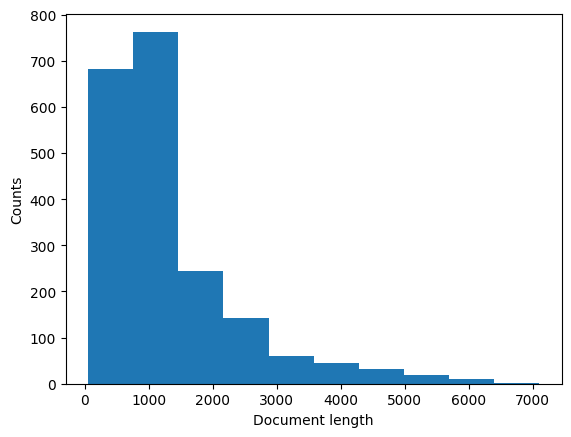

In [47]:
import matplotlib.pyplot as plt
# plot the distribution of lengths in an histogram
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(train_doc_lengths)
ax.set_xlabel('Document length')
_ =ax.set_ylabel('Counts')


We can see that there are many shorter documents, and few longer ones. Is it the same for the number of tokens?

In [48]:
# get the number of tokens in each document
train_doc_tokens= []
for doc in train_processed:
  train_doc_tokens.append(len(doc)) #the length of a spaCy document is the number of tokens



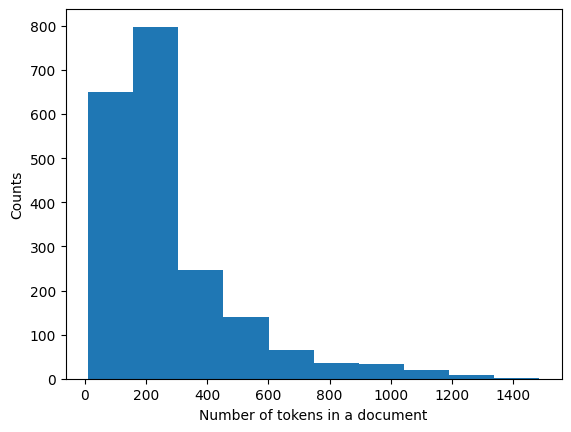

In [49]:
import matplotlib.pyplot as plt
# plot the distribution of lengths in an histogram
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(train_doc_tokens)
ax.set_xlabel('Number of tokens in a document') #label your axes if you can!
_ =ax.set_ylabel('Counts')


The shape of the distribution looks similar but the absolute numbers are different.

But are the distributions different depending on whether a review is positive or negative? Let's find out...

In [50]:
# let's cycle through the documents again, but this time we'll keep track of positive
# and negative reviews separately
pos_train_doc_tokens= []
neg_train_doc_tokens= []
for i,doc in enumerate(train_processed):
  if train_dataset.iloc[i]['target']=='pos':
    pos_train_doc_tokens.append(len(doc)) #the length of a spaCy document is the number of tokens
  else:
    neg_train_doc_tokens.append(len(doc))



In [51]:
# as a side note, let's double check whether the first 2000 documents have high class imbalance.
# We'll see that the distribution is not exactly 50/50 but it's not too bad
train_dataset.iloc[:2000].target.value_counts()


pos    1034
neg     966
Name: target, dtype: int64

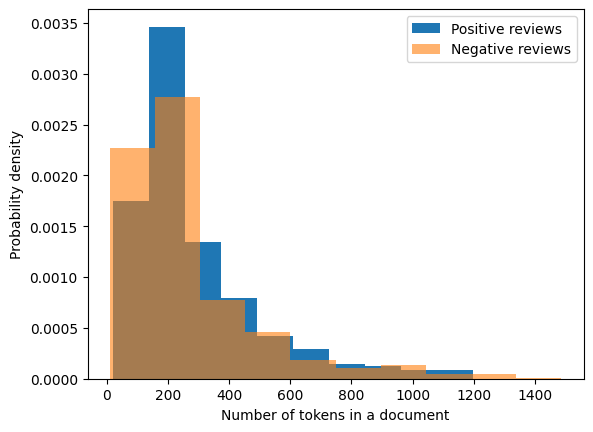

In [52]:
import matplotlib.pyplot as plt
# plot the distribution of lengths in an histogram
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(pos_train_doc_tokens, density=True) # density normalises the histograms so that we can compare two distributions more easily
ax.hist(neg_train_doc_tokens, alpha=0.6, density=True)
ax.set_xlabel('Number of tokens in a document')
_ =ax.set_ylabel('Probability density')
_= ax.legend(['Positive reviews','Negative reviews'])


We'd need to do a statistical test to verify whether there are actual differences, but at a first glance there don't seem to be many differences...

Sometimes short text are synonyms with noise or irrelevant data. Certainly if you have an empty text that would be an invalid data points! (**so, check for texts of length 0 during the EDA**)

However, for certain problems short texts are to be expected. For example, a film review could be as short as "great film!"...

What are examples of very short texts and very long texts?


In [53]:
# get the minimum token length:
print('Minimum number of tokens: ', np.min(train_doc_tokens))
print('Maximum number of tokens: ', np.max(train_doc_tokens))
print()

print('Example of short text:')
# print the first document less than 25 tokens
for i,doc in enumerate(train_processed):
  if len(doc)<25:
    print(doc.text)
    break

print()
print('Example of long text:')
# print the first document more than 1200 tokens
for i,doc in enumerate(train_processed):
  if len(doc)>1200:
    print(doc.text)
    break



Minimum number of tokens:  11
Maximum number of tokens:  1485

Example of short text:
Ming The Merciless does a little Bardwork and a movie most foul!

Example of long text:
Okay, so I'm not a big video game buff, but was the game House of the Dead really famous enough to make a movie from? Sure, they went as far as to actually put in quick video game clips throughout the movie, as though justifying any particular scene of violence, but there are dozens and dozens of games that look exactly the same, with the hand in the bottom on the screen, supposedly your own, holding whatever weapon and goo-ing all kinds of aliens or walking dead or snipers or whatever the case may be.



It's an interesting premise in House of the Dead, with a lot of college kids (LOADED college kids, as it were, kids who are able to pay some fisherman something like $1,500 just for a ride after they miss their boat) trying to get out to this island for what is supposed to be the rave of the year. The first thing 

## Word clouds

Word clouds are ways to show the frequencies of the tokens in a corpus in a more visual ways. It shows each token in the corpus with a size proportional to how often it appears.

To generate wordclouds we will use the python package [wordcloud](https://github.com/amueller/word_cloud).

Notes:
1. We need to generate wordclouds from a string, not a list of document. To do this, we need to join all documents together.
2. We can also generate wordclouds from frequencies, using the output of countvectorizer (and, potentially, spacy). This is left for you to research as an exercise. (hint: [here](https://github.com/amueller/word_cloud/blob/master/examples/frequency.py) is an example from the package documentation)

In [54]:
!pip install wordcloud

In [55]:
from wordcloud import WordCloud

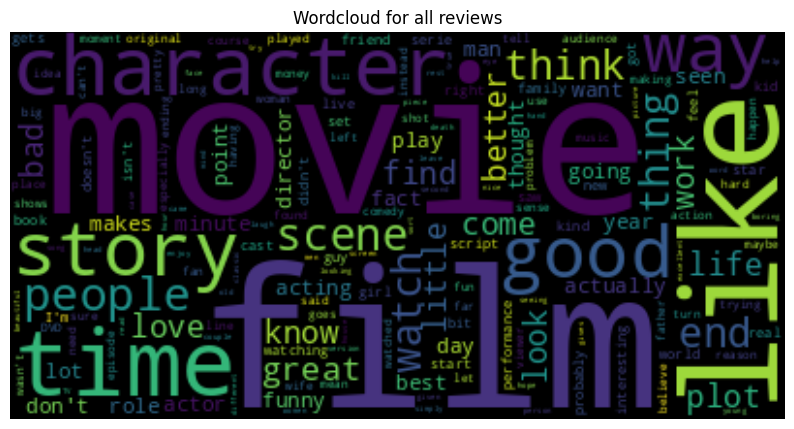

In [56]:
wordcloud = WordCloud(stopwords = spacy_stopwords).generate(' '.join(train_dataset['review'].tolist()))
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
_ = plt.title('Wordcloud for all reviews')


As before, we can show the wordclouds separately for positive and negative reviews.


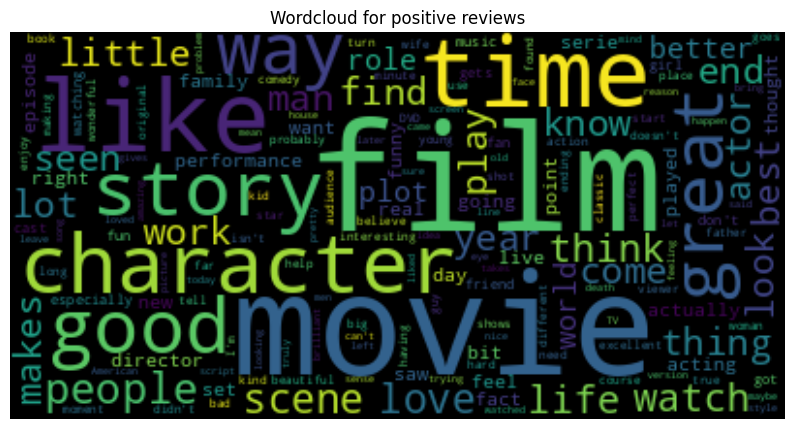

In [40]:
# Positive reviews
pos_wordcloud = WordCloud(stopwords = spacy_stopwords).generate(
    ' '.join(train_dataset[train_dataset['target']=='pos']['review'].tolist()))
plt.figure(figsize=[10,10])
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
_ = plt.title('Wordcloud for positive reviews')


### Exercise 3
Plot the word cloud for the negative review (remember the label value is `'neg'`).

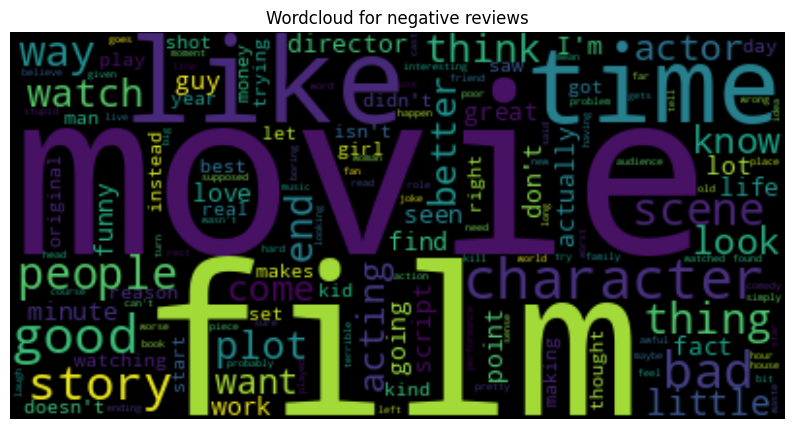

In [60]:
### YOUR CODE HERE ###
# Negative reviews
neg_wordcloud = WordCloud(stopwords = spacy_stopwords).generate(
    ' '.join(train_dataset[train_dataset['target']=='neg']['review'].tolist()))
plt.figure(figsize=[10,10])
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
_ = plt.title('Wordcloud for negative reviews')

# Resources

[1] Y. Liu (2020) [Python Machine Learning by Example](https://www.packtpub.com/product/python-machine-learning-by-example-third-edition/9781800209718), Chapter 2. Available via the library.

[2] [Advanced NLP with spaCy](https://course.spacy.io/en)


#### Advanced resources

There are many other python packages built on top of Spacy that helps you do more with text data. One of these is `textDescriptive` ([github repo](https://github.com/HLasse/TextDescriptives)), which can help you compute a large collection of descriptive statistics from text. Try it out after class if you have time.